In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Polygon, Point, LineString, MultiPolygon
from room import Room

In [2]:
gdf = gpd.read_file('tenbenham.geojson')

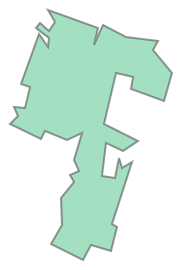

In [3]:
room = gdf.iloc[0].geometry
room

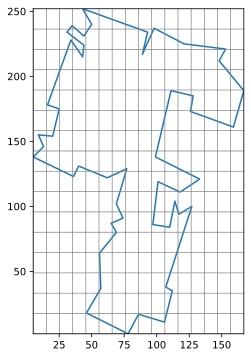

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
minx, miny, maxx, maxy = room.bounds
room_x, room_y = room.exterior.coords.xy
ax.plot(room_x, room_y)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
for i in range(16):
    ax.axvline(minx + ((maxx - minx) * (i / 16)),
               linewidth=0.7,
               color='gray')
    ax.axhline(miny + ((maxy - miny) * (i / 16)),
               linewidth=0.7,
               color='gray')
plt.show()

In [5]:
height = 0.1
min_intensity = 1

In [6]:
room = Room(gdf,
            guard_scale=0.9,
            room_res=200,
            guard_res=800)

In [7]:
# Branch and bound algorithm: divide the rectangle up into subrectangles,
# splitting along the longest side. Lower/upper bound the illumination
# at each rectangle by determining illumination at the corners and taking
# min/max illuminations.
def box_intersection(room, bounds):
    inter = box(*bounds).intersection(room.room)
    fig, ax = plt.subplots()
    ax.scatter(room.guard_grid[:, 0], room.guard_grid[:, 1], marker='.')
    ax.plot(*box(*bounds).exterior.coords.xy, color='red', linestyle='dotted')
    ax.plot(*room.room.exterior.coords.xy, color='gray', linestyle='--')
    if isinstance(inter, Polygon) and not inter.is_empty:
        ax.plot(*inter.exterior.coords.xy)
        plt.show()
        return inter, inter.exterior.coords.xy
    elif isinstance(inter, MultiPolygon) and not inter.is_empty:
        xs, ys = inter[0].exterior.coords.xy
        ax.plot(xs, ys)
        for part in inter[1:]:
            part_x, part_y = part.exterior.coords.xy
            ax.plot(xs, ys)
            xs = np.append(xs, part_x)
            ys = np.append(ys, part_y)
        plt.show()
        return inter, (xs, ys)
    return None, None


def box_sightlines(room, exterior_coords):
    sightlines = np.zeros((len(exterior_coords[0]), room.guard_grid.shape[0]))
    for ext_idx, (x, y) in enumerate(zip(*exterior_coords)):
        for guard_idx, guard_point in enumerate(room.guard_grid):
            sight = LineString([guard_point, (x, y)])
            if room.room.contains(sight):
                sightlines[ext_idx, guard_idx] = 1
    return sightlines
    

def box_intensities(room, weights, exterior_coords):
    box_x, box_y = exterior_coords
    gx = room.guard_grid[:, 0]
    gy = room.guard_grid[:, 1]
    intensities = np.zeros((len(box_x), room.guard_grid.shape[0]))
    for idx, (x, y) in enumerate(zip(box_x, box_y)):
        intensities[idx] = weights / (((x - gx) ** 2) + ((y - gy) ** 2) + height)
    return intensities

In [8]:
def illumination_lower_bound(room, weights, sightlines, exterior_coords):
    intensities = box_intensities(room, weights, exterior_coords)
    intensities[sightlines == 0] = np.inf
    min_intensities = np.min(intensities, axis=0)
    min_intensities[min_intensities == np.inf] = 0
    return np.sum(min_intensities)

def illumination_upper_bound(room, weights, sightlines, poly):
    distances = np.zeros(room.guard_grid.shape[0])
    for idx, (x, y) in enumerate(room.guard_grid):
        if poly.contains(Point(x, y)):
            # Case: guard point within box.
            distances[idx] = 0
        else:
            if isinstance(poly, MultiPolygon):
                distances[idx] = min(p.exterior.distance(Point(x, y))
                                     for p in poly)**2
            else:
                 distances[idx] = poly.exterior.distance(Point(x, y))**2
    distances += height
    return np.sum(np.multiply(weights / distances,
                  np.max(sightlines, axis=0)))

In [9]:
def branch_bound_poly(room, weights, max_iters=15, epsilon=1e-5):
    rects = [room.room.bounds]
    outer_poly, outer_points = box_intersection(room, rects[0])
    outer_sightlines = box_sightlines(room, outer_points)
    lbs = [illumination_lower_bound(room, weights,
                                    outer_sightlines, outer_points)]
    ubs = [illumination_upper_bound(room, weights,
                                    outer_sightlines, outer_poly)]
    L_idx = 0
    Q = rects[0]
    L = lbs[0]
    U = ubs[0]
    
    for i in range(max_iters):
        print(i, L, U, U - L)
        if U - L <= epsilon:
            break
        # Split Q along its longest side and replace with Q1, Q2.
        minx, miny, maxx, maxy = Q
        width = maxx - minx
        height = maxy - miny
        if width > height:
            Q1 = (minx, miny, minx + (maxx - minx) / 2, maxy)
            Q2 = (minx + (maxx - minx) / 2, miny, maxx, maxy)
        else:
            Q1 = (minx, miny, maxx, miny + (maxy - miny) / 2)
            Q2 = (minx, miny + (maxy - miny) / 2, maxx, maxy)
            
        # We have created two new boxes. Inductively, one of them
        # should intersect with the room polygon, but the other
        # may not. We remove this box entirely.
        Q1_poly, Q1_points = box_intersection(room, Q1)
        Q2_poly, Q2_points = box_intersection(room, Q2)
        if not Q1_poly:
            Q2_sightlines = box_sightlines(room, Q2_points)
            rects[L_idx] = Q2
            lbs[L_idx] = illumination_lower_bound(room, weights,
                                                  Q2_sightlines, Q2_points)
            ubs[L_idx] = illumination_upper_bound(room, weights,
                                                  Q2_sightlines, Q2_poly)
        else:
            Q1_sightlines = box_sightlines(room, Q1_points)
            rects[L_idx] = Q1
            lbs[L_idx] = illumination_lower_bound(room, weights,
                                                  Q1_sightlines, Q1_points)
            ubs[L_idx] = illumination_upper_bound(room, weights,
                                                  Q1_sightlines, Q1_poly)
            if Q2_poly:
                Q2_sightlines = box_sightlines(room, Q2_points)
                rects.append(Q2)
                lbs.append(illumination_lower_bound(room, weights,
                                                    Q2_sightlines, Q2_points))
                ubs.append(illumination_upper_bound(room, weights,
                                                     Q2_sightlines, Q2_poly))
                
        # Update bounds.
        L_idx = np.argmin(lbs)
        Q = rects[L_idx]
        L = np.min(lbs)
        U = np.min(ubs)
    return Q, L, U

In [10]:
random_weights = np.random.random(room.guard_grid.shape[0])

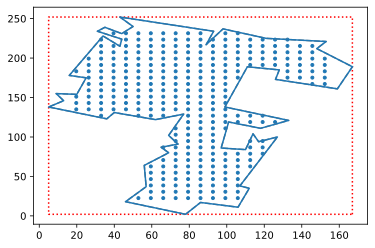

0 0.007619488263363072 1488.4226219219831 1488.4150024337198


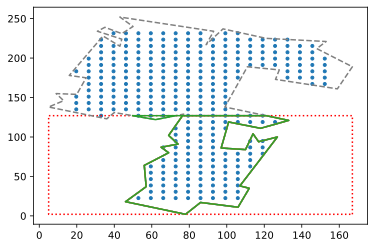

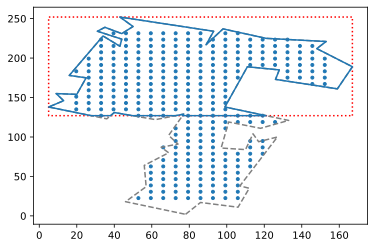

1 0.009701716929115159 536.8741710970905 536.8644693801614


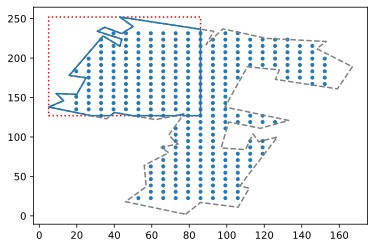

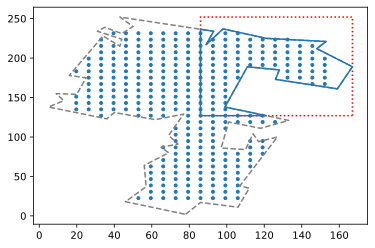

2 0.01780664480883039 415.77005976135206 415.7522531165432


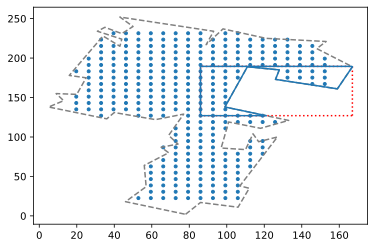

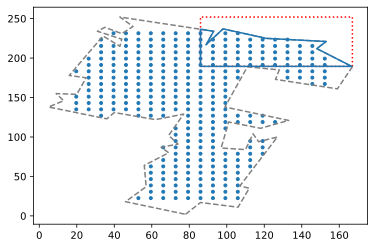

3 0.01750145907641038 173.64164131559733 173.6241398565209


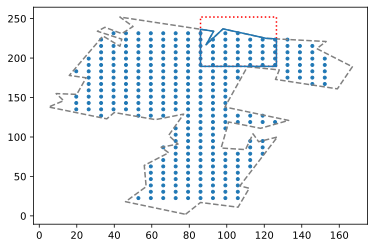

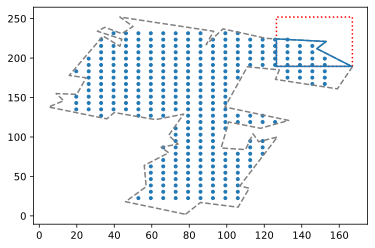

4 0.01755939480037425 73.80216085570976 73.78460146090939


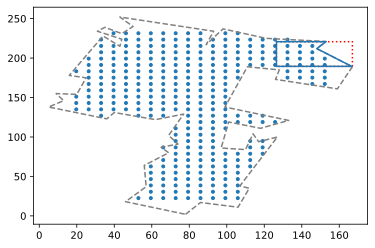

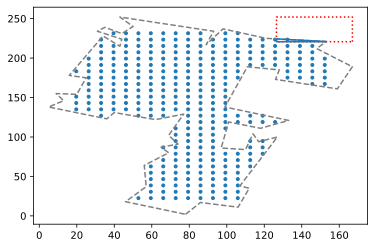

5 0.01878899262361504 5.811461403997711 5.792672411374096


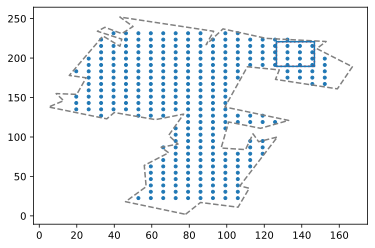

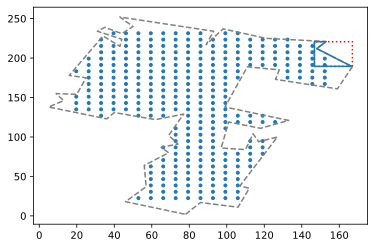

6 0.02000670415902737 5.811461403997711 5.791454699838684


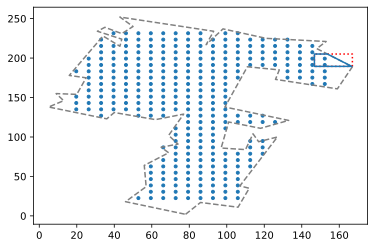

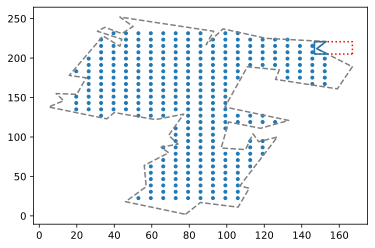

7 0.022867260561576515 0.3913464587190807 0.3684791981575042


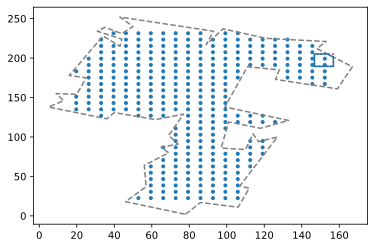

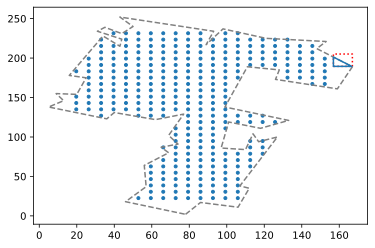

8 0.022501816816708882 0.09522530046521074 0.07272348364850187


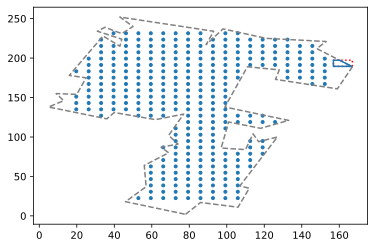

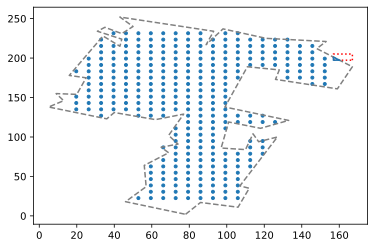

9 0.02294382900019666 0.07999949435776772 0.05705566535757106


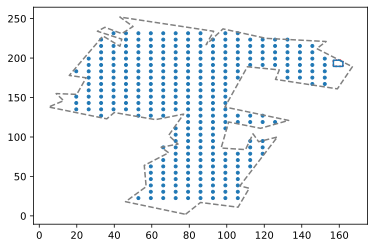

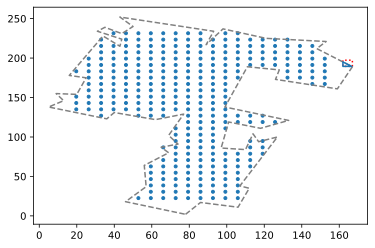

10 0.023024645299668217 0.03716782183581792 0.014143176536149701


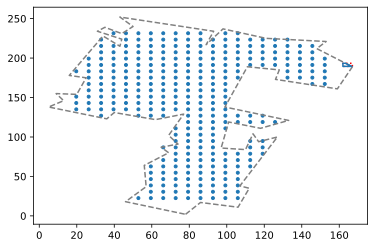

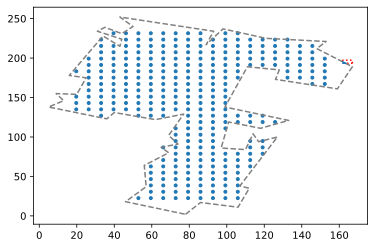

11 0.022977247693322256 0.03410374706541411 0.011126499372091852


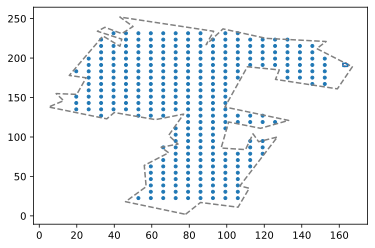

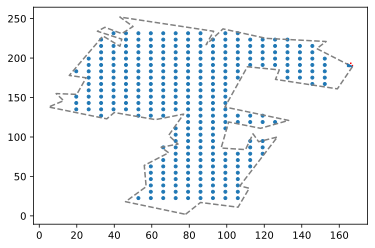

12 0.022634908773389886 0.027497452505379882 0.004862543731989997


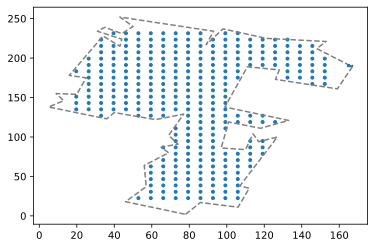

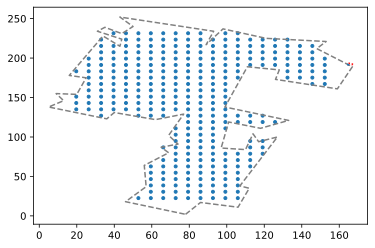

13 0.022550495167809673 0.026683509654439372 0.004133014486629699


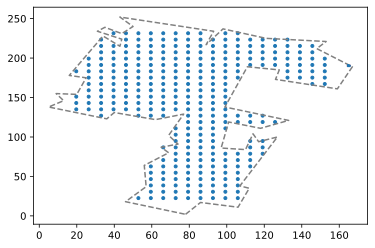

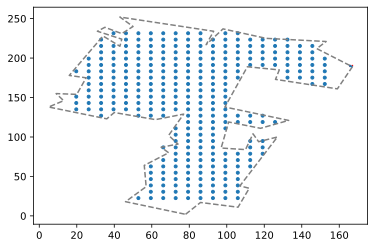

14 0.02259547825786829 0.024397958131855295 0.0018024798739870035


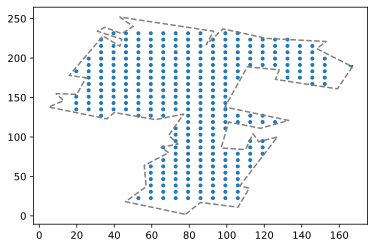

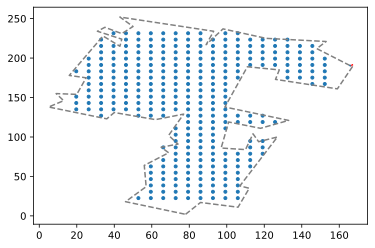

((165.734375, 189.5, 167.0, 190.4765625),
 0.022602762684980068,
 0.024066613151491938)

In [11]:
branch_bound_poly(room, random_weights)